**Общая информация**

**Срок сдачи:** 18 октября 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 18 октября, -4 балла после 06:00 25 октября, -6 баллов после 06:00 1 ноября

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 4 (3 балла)
Добавить algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Значение n_neighbors нужно взять из задания 3. Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

###### Задание 5 (1 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять структуру кода и текст. В противном случае -1 балл


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import sklearn.metrics
import collections
from scipy import stats
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
%load_ext pycodestyle_magic

In [2]:
%%pycodestyle


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm

    def fit(self, X, y):
        import copy
        self.X_train = copy.deepcopy(X)
        self.y_train = copy.deepcopy(y)
        self.classes_amount = list(collections.Counter(self.y_train)).__len__()
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(self.X_train, leaf_size=30)

    def predict(self, X):
        if self.algorithm == 'brute':
            return self.predict_brute(X)
        elif self.algorithm == 'kd_tree':
            return self.predict_kdtree(X)

    def predict_brute(self, X_test):
        prediction_size = X_test.shape[0]
        distance_matrix = sklearn.metrics.pairwise_distances(X_test,
                                                             self.X_train)
        close_elements = np.argpartition(distance_matrix,
                                         (range(self.n_neighbors))
                                         )[:, :self.n_neighbors]
        close_class = y_train[close_elements]
        class_matrix = np.zeros(prediction_size)
        for elem in range(prediction_size):
            class_matrix[elem] = collections.Counter(
                                    close_class[elem]).most_common(1)[0][0]
        return class_matrix.astype('int32')

    def predict_kdtree(self, X):
        X = X.astype(float)
        _, a = self.tree.query(X, k=self.n_neighbors)
        predicted = self.y_train[a].T
        return stats.mode(predicted)[0].reshape(-1)

    def predict_proba(self, X):
        if self.algorithm == 'brute':
            return self.predict_proba_brute(X)
        elif self.algorithm == 'kd_tree':
            return self.predict_proba_kdtree(X)

    def predict_proba_brute(self, X_test):
        X_test = X_test.astype(float)
        distance_matrix = np.matmul(X_test, self.X_train.T)
        Test_sqr = ((X_test ** 2).sum(axis=1)).reshape(-1, 1)
        Train_sqr = ((self.X_train ** 2).sum(axis=1)).reshape(1, -1)
        final_dist = Test_sqr - 2 * distance_matrix + Train_sqr
        predicted = self.y_train[np.argsort(final_dist)[:, :self.n_neighbors]]
        res_matrix = np.zeros((predicted.shape[0], self.classes_amount))
        for i in range(predicted.shape[0]):
            c = collections.Counter(predicted[i])
            res_matrix[i] = [float(c[j])/self.n_neighbors for j in
                             range(self.classes_amount)]
        return res_matrix

    def predict_proba_kdtree(self, X):
        X = X.astype(float)
        _, a = self.tree.query(X, k=self.n_neighbors)
        res_matrix = np.zeros((np.shape(X)[0], self.classes_amount))
        for i in range(a.shape[0]):
            for j in a[i]:
                res_matrix[i][int(self.y_train[j])] += 1
        return res_matrix / self.n_neighbors

    def score(self, X, y):
        return np.average(y == self.predict(X))

In [3]:
#Добавлен второй блок, чтобы показать, что код соответствует PEP8,
#потому что блок, содержаший %%pycodestyle, не считается выполненным(?)
class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm

    def fit(self, X, y):
        import copy
        self.X_train = copy.deepcopy(X)
        self.y_train = copy.deepcopy(y)
        self.classes_amount = list(collections.Counter(self.y_train)).__len__()
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(self.X_train, leaf_size=30)

    def predict(self, X):
        if self.algorithm == 'brute':
            return self.predict_brute(X)
        elif self.algorithm == 'kd_tree':
            return self.predict_kdtree(X)

    def predict_brute(self, X_test):
        prediction_size = X_test.shape[0]
        distance_matrix = sklearn.metrics.pairwise_distances(X_test,
                                                             self.X_train)
        close_elements = np.argpartition(distance_matrix,
                                         (range(self.n_neighbors))
                                         )[:, :self.n_neighbors]
        close_class = y_train[close_elements]
        class_matrix = np.zeros(prediction_size)
        for elem in range(prediction_size):
            class_matrix[elem] = collections.Counter(
                                    close_class[elem]).most_common(1)[0][0]
        return class_matrix.astype('int32')

    def predict_kdtree(self, X):
        X = X.astype(float)
        _, a = self.tree.query(X, k=self.n_neighbors)
        predicted = self.y_train[a].T
        return stats.mode(predicted)[0].reshape(-1)

    def predict_proba(self, X):
        if self.algorithm == 'brute':
            return self.predict_proba_brute(X)
        elif self.algorithm == 'kd_tree':
            return self.predict_proba_kdtree(X)

    def predict_proba_brute(self, X_test):
        X_test = X_test.astype(float)
        distance_matrix = np.matmul(X_test, self.X_train.T)
        Test_sqr = ((X_test ** 2).sum(axis=1)).reshape(-1, 1)
        Train_sqr = ((self.X_train ** 2).sum(axis=1)).reshape(1, -1)
        final_dist = Test_sqr - 2 * distance_matrix + Train_sqr
#        final_dist = np.sqrt(final_dist)
#        Not used because of unclear negative number appearance.
#        Doesn't matter what we compare: distance or distance*distance.
        predicted = self.y_train[np.argsort(final_dist)[:, :self.n_neighbors]]
        res_matrix = np.zeros((predicted.shape[0], self.classes_amount))
        for i in range(predicted.shape[0]):
            c = collections.Counter(predicted[i])
            res_matrix[i] = [float(c[j])/self.n_neighbors for j in
                             range(self.classes_amount)]
        return res_matrix

    def predict_proba_kdtree(self, X):
        X = X.astype(float)
        _, a = self.tree.query(X, k=self.n_neighbors)
        res_matrix = np.zeros((np.shape(X)[0], self.classes_amount))
        for i in range(a.shape[0]):
            for j in a[i]:
                res_matrix[i][int(self.y_train[j])] += 1
        return res_matrix / self.n_neighbors

    def score(self, X, y):
        return np.average(y == self.predict(X))

**IRIS**

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [7]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [8]:
%time my_clf.fit(X_train, y_train)

Wall time: 996 µs


In [9]:
%time clf.predict(X_test)

Wall time: 12 ms


array([2, 1, 1, 1, 2, 2, 0, 1, 0, 0, 2, 0, 2, 0, 1])

In [10]:
%time my_clf.predict(X_test)

Wall time: 0 ns


array([2, 1, 1, 1, 2, 2, 0, 1, 0, 0, 2, 0, 2, 0, 1])

In [11]:
%time clf.predict_proba(X_test)

Wall time: 997 µs


array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [12]:
%time my_clf.predict_proba(X_test)

Wall time: 0 ns


array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [13]:
clf.score(X_test, y_test)

1.0

In [14]:
my_clf.score(X_test, y_test)

1.0

Задание 3

In [15]:
res_list = []
loops_amount = 100
MAX_NEIGHBORS = 50
for i in range(1, MAX_NEIGHBORS):
    q = []
    for j in range(loops_amount):
        X_train, X_test, y_train, y_test = train_test_split(iris.data, 
                                                            iris.target, 
                                                            test_size=0.1, 
                                                            stratify=iris.target)
        clf = MyKNeighborsClassifier(n_neighbors=i)
        clf.fit(X_train, y_train)
        q.append(clf.score(X_test, y_test))
    res_list.append(np.mean(q))

In [16]:
res_list = np.array(res_list)
IRIS_NEIGHBORS = res_list.argmax()+1
IRIS_NEIGHBORS

14

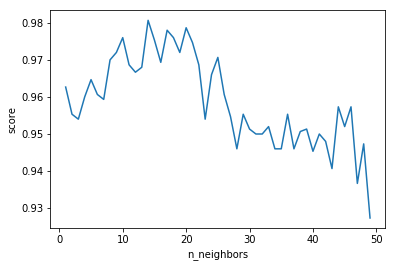

In [17]:
plt.plot(range(1, MAX_NEIGHBORS), res_list)
plt.xlabel("n_neighbors")
plt.ylabel("score")
plt.show()

**MNIST**

In [18]:
mnist = fetch_mldata('MNIST original')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [20]:
clf = KNeighborsClassifier(n_neighbors=IRIS_NEIGHBORS, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=IRIS_NEIGHBORS)

In [21]:
%time clf.fit(X_train, y_train)

Wall time: 8.08 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=14, p=2,
           weights='uniform')

In [22]:
%time my_clf.fit(X_train, y_train)

Wall time: 46.9 ms


In [23]:
%time clf.predict(X_test)

Wall time: 2.16 s


array([9., 1., 7., 6., 7., 2., 3., 6., 1., 6., 0., 2., 7., 4., 6., 1., 4.,
       5., 9., 4., 3., 6., 1., 8., 1., 8., 0., 7., 3., 9., 7., 5., 8., 1.,
       6., 4., 5., 2., 5., 3., 2., 3., 7., 1., 1., 8., 1., 6., 0., 5., 4.,
       0., 7., 0., 9., 3., 9., 3., 3., 3., 5., 2., 8., 0., 3., 2., 0., 7.,
       4., 1., 9., 4., 0., 1., 9., 1., 1., 9., 6., 5., 2., 2., 4., 3., 0.,
       9., 0., 1., 3., 1., 8., 4., 4., 1., 8., 4., 0., 6., 6., 1., 3., 7.,
       1., 2., 5., 6., 7., 7., 6., 9., 1., 3., 1., 6., 2., 7., 6., 6., 2.,
       2., 0., 1., 2., 8., 7., 1., 2., 2., 6., 7., 7., 0., 9., 1., 9., 5.,
       7., 5., 6., 9., 3., 3., 4., 5., 5., 8., 9., 4., 5., 3., 3., 7., 0.,
       9., 0., 4., 8., 0., 4., 2., 5., 6., 0., 1., 7., 7., 4., 0., 7., 0.,
       1., 6., 7., 3., 8., 5., 7., 4., 9., 8., 6., 1., 8., 7., 8., 1., 3.,
       6., 5., 6., 4., 4., 7., 8., 7., 0., 1., 5., 9., 0., 9., 5., 3., 7.,
       1., 4., 5., 5., 4., 0., 8., 3., 5., 0., 3., 4., 7., 7., 0., 3., 6.,
       2., 6., 0., 5., 2.

In [24]:
%time my_clf.predict(X_test)

Wall time: 2.3 s


array([9, 1, 7, 6, 7, 2, 3, 6, 1, 6, 0, 2, 7, 4, 6, 1, 4, 5, 9, 4, 3, 6,
       1, 8, 1, 8, 0, 7, 3, 9, 7, 5, 8, 1, 6, 4, 5, 2, 5, 3, 2, 3, 7, 1,
       1, 8, 1, 6, 0, 5, 4, 0, 7, 0, 9, 3, 9, 3, 3, 3, 8, 2, 8, 0, 3, 2,
       0, 7, 4, 1, 9, 4, 0, 1, 9, 1, 1, 9, 6, 5, 2, 2, 4, 3, 0, 9, 0, 1,
       3, 1, 8, 4, 4, 1, 8, 4, 0, 6, 6, 1, 3, 7, 1, 2, 5, 6, 7, 7, 6, 9,
       1, 3, 1, 6, 2, 7, 6, 6, 2, 2, 0, 1, 2, 8, 7, 1, 2, 2, 6, 7, 7, 0,
       9, 1, 9, 5, 7, 5, 6, 9, 3, 3, 4, 5, 5, 8, 9, 4, 5, 3, 3, 7, 0, 9,
       0, 4, 8, 0, 4, 2, 5, 6, 0, 1, 7, 7, 4, 0, 7, 0, 1, 6, 7, 3, 8, 5,
       7, 4, 9, 8, 6, 1, 8, 7, 8, 1, 3, 6, 5, 6, 4, 4, 7, 8, 7, 0, 1, 5,
       9, 0, 9, 5, 3, 7, 1, 4, 5, 5, 4, 0, 8, 3, 5, 0, 3, 4, 7, 7, 0, 3,
       6, 2, 6, 0, 5, 2, 0, 3, 9, 1, 7, 5, 7, 2, 2, 5, 7, 0, 9, 9, 9, 3,
       5, 6, 4, 5, 9, 9, 1, 4, 9, 1, 3, 8, 5, 5, 0, 3, 6, 4, 2, 0, 8, 5,
       4, 6, 2, 5, 6, 8, 9, 2, 6, 6, 2, 9, 8, 2, 4, 3, 8, 4, 0, 1, 0, 7,
       0, 5, 5, 1, 1, 7, 4, 6, 0, 6, 4, 1, 1, 6, 5,

In [25]:
%time clf.predict_proba(X_test)

Wall time: 2.04 s


array([[0.        , 0.        , 0.        , ..., 0.07142857, 0.        ,
        0.85714286],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.35714286, ..., 0.64285714, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [26]:
%time my_clf.predict_proba(X_test)

Wall time: 6.69 s


array([[0.        , 0.        , 0.        , ..., 0.        , 0.35714286,
        0.64285714],
       [0.        , 0.42857143, 0.28571429, ..., 0.        , 0.14285714,
        0.        ],
       [0.14285714, 0.        , 0.78571429, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.21428571],
       [0.        , 0.        , 0.        , ..., 0.        , 0.07142857,
        0.92857143],
       [0.21428571, 0.        , 0.        , ..., 0.        , 0.35714286,
        0.35714286]])

In [27]:
clf.score(X_test, y_test)

0.9642857142857143

In [28]:
my_clf.score(X_test, y_test)

0.9685714285714285

Задание 4

In [29]:
clf = KNeighborsClassifier(n_neighbors=IRIS_NEIGHBORS, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=IRIS_NEIGHBORS, algorithm='kd_tree')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [31]:
%time clf.fit(X_train, y_train)

Wall time: 26.7 s


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=14, p=2,
           weights='uniform')

In [32]:
%time my_clf.fit(X_train, y_train)

Wall time: 26.2 s


In [33]:
%time clf.predict(X_test)

Wall time: 1min 23s


array([8., 8., 6., 8., 3., 6., 0., 1., 2., 5., 4., 8., 9., 4., 3., 0., 1.,
       9., 7., 8., 9., 9., 4., 8., 4., 7., 0., 7., 2., 6., 6., 3., 0., 8.,
       5., 9., 2., 2., 0., 9., 5., 8., 3., 7., 2., 8., 8., 4., 2., 6., 4.,
       4., 5., 4., 9., 2., 0., 4., 8., 2., 1., 7., 7., 0., 3., 9., 0., 1.,
       1., 2., 3., 2., 7., 8., 9., 1., 3., 1., 9., 7., 1., 3., 3., 1., 3.,
       4., 5., 9., 7., 1., 2., 5., 4., 8., 5., 6., 4., 3., 4., 1., 7., 8.,
       4., 8., 6., 2., 3., 7., 5., 4., 3., 1., 3., 9., 9., 0., 2., 8., 5.,
       3., 7., 9., 4., 7., 3., 9., 1., 8., 3., 3., 1., 4., 7., 7., 3., 5.,
       7., 5., 6., 1., 4., 1., 6., 9., 8., 7., 2., 4., 6., 8., 8., 6., 3.,
       6., 4., 4., 3., 4., 2., 2., 7., 4., 3., 1., 8., 7., 2., 3., 4., 1.,
       1., 3., 0., 0., 0., 9., 8., 2., 5., 2., 1., 9., 9., 1., 9., 2., 4.,
       5., 5., 6., 1., 5., 4., 0., 8., 9., 9., 1., 4., 6., 1., 8., 3., 7.,
       8., 1., 1., 3., 3., 5., 6., 6., 3., 9., 3., 0., 5., 8., 0., 0., 9.,
       9., 4., 8., 6., 1.

In [34]:
%time my_clf.predict(X_test)

Wall time: 1min 20s


array([8., 8., 6., 8., 3., 6., 0., 1., 2., 5., 4., 8., 9., 4., 3., 0., 1.,
       9., 7., 8., 9., 9., 4., 8., 4., 7., 0., 7., 2., 6., 6., 3., 0., 8.,
       5., 9., 2., 2., 0., 9., 5., 8., 3., 7., 2., 8., 8., 4., 2., 6., 4.,
       4., 5., 4., 9., 2., 0., 4., 8., 2., 1., 7., 7., 0., 3., 9., 0., 1.,
       1., 2., 3., 2., 7., 8., 9., 1., 3., 1., 9., 7., 1., 3., 3., 1., 3.,
       4., 5., 9., 7., 1., 2., 5., 4., 8., 5., 6., 4., 3., 4., 1., 7., 8.,
       4., 8., 6., 2., 3., 7., 5., 4., 3., 1., 3., 9., 9., 0., 2., 8., 5.,
       3., 7., 9., 4., 7., 3., 9., 1., 8., 3., 3., 1., 4., 7., 7., 3., 5.,
       7., 5., 6., 1., 4., 1., 6., 9., 8., 7., 2., 4., 6., 8., 8., 6., 3.,
       6., 4., 4., 3., 4., 2., 2., 7., 4., 3., 1., 8., 7., 2., 3., 4., 1.,
       1., 3., 0., 0., 0., 9., 8., 2., 5., 2., 1., 9., 9., 1., 9., 2., 4.,
       5., 5., 6., 1., 5., 4., 0., 8., 9., 9., 1., 4., 6., 1., 8., 3., 7.,
       8., 1., 1., 3., 3., 5., 6., 6., 3., 9., 3., 0., 5., 8., 0., 0., 9.,
       9., 4., 8., 6., 1.

In [35]:
%time clf.predict_proba(X_test)

Wall time: 1min 23s


array([[0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.85714286]])

In [36]:
%time my_clf.predict_proba(X_test)

Wall time: 1min 21s


array([[0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.85714286]])

In [37]:
clf.score(X_test, y_test)

0.9714285714285714

In [38]:
my_clf.score(X_test, y_test)

0.9714285714285714

Задание 5

In [ ]:
# seaborn
Библиотека для визуализации данных (построения разных графиков), базируется на matplotlib
# matplotlib
Библиотека для визуаизации данных двумерной(трёхмерной) графикой
# train_test_split
Функция для разделения обучающих данных на две части: обучающую выборку и тестовую
# Pipelin%load_ext e (from sklearn.pipeline import Pipeline)
Инструмент (?) для последовательного преобразования данных. Работает аналогично конвейеру bash'a
# StandardScaler (from sklearn.preprocessing import StandardScaler)
Класс, предназначенный для нормировки данных
# ClassifierMixin
Класс, родительский для всех классификаторов из sklearn
# NeighborsBase
Класс, родительский для всех классов neighbors-предсказателей из sklearn
# KNeighborsMixin
Класс, родительский для всех классов, включающих метод поиска ближайших соседей
# SupervisedIntegerMixin
Базовый класс для классификаторов, необходимый для реализации метода fit()